# Notebook 3: Retrieve Echotop Field from Pre-Computed Data

In Notebook 2, we pre-computed the Echotop variable from raw model data and stored it back into FDB. Now, in Notebook 3, our objective is to retrieve this pre-computed echo-top field. This field, initially not generated as part of the model's output, is highly valuable for numerous downstream applications, making it of considerable interest for many users to retrieve. Additionally, we apply a regridding of the data to the Swiss grid coordinate system (EPSG code 21781) to showcase another feature. By accessing this stored data, we streamline the process of accessing and utilizing essential meteorological information, enabling smoother workflows and improved insights.

1. **Configuring Access to Polytope**

In [1]:
import os

os.environ["POLYTOPE_ADDRESS"] = "https://polytope-dev.mchml.cscs.ch"
#os.environ["POLYTOPE_USERNAME"] = "admin"
#os.environ["POLYTOPE_PASSWORD"] = "xxxxxxxxxxxxx"


2. **Querying Data**

The below query will only work if the previous notebook was successfully run (in full) by the designated service account at CSCS which has permissions to write back the ECHOTOPinM field to FDB.

In [2]:
from meteodatalab import mars, mch_model_data

request = mars.Request(
    param="ECHOTOPinM",
    date="20240409",
    time="1800",
    number=0,
    step=60,
    levtype=mars.LevType.SURFACE,
    model=mars.Model.ICON_CH1_EPS,
)

ds = mch_model_data.get_from_polytope(request)


2024-04-24 12:58:45 - INFO - Sending request...
{'request': 'class: od\n'
            "date: '20240409'\n"
            "expver: '0001'\n"
            'levtype: sfc\n'
            'model: icon-ch1-eps\n'
            'number: 0\n'
            "param: '503422'\n"
            'step: 60\n'
            'stream: enfo\n'
            "time: '1800'\n"
            'type: ememb\n',
 'verb': 'retrieve'}
2024-04-24 12:58:45 - INFO - Request accepted. Please poll https://polytope-dev.mchml.cscs.ch/api/v1/requests/61b1b951-339a-4a5b-bc3e-71fa68b74c7f for status
2024-04-24 12:58:45 - INFO - Checking request status (61b1b951-339a-4a5b-bc3e-71fa68b74c7f)...
2024-04-24 12:58:46 - INFO - The current status of the request is 'queued'
2024-04-24 12:58:49 - INFO - The current status of the request is 'processing'
2024-04-24 12:59:01 - INFO - The current status of the request is 'processed'
ECCODES ERROR   :  unpack_string: Wrong size (1025) for bitmap, it contains 114953 values


3. **Regridding to the Swiss grid coordinate system**

In [3]:
from meteodatalab.operators.regrid import regrid, RegularGrid, Resampling, CRS

echo_top = ds["ECHOTOPinM"]
dst = RegularGrid(
    crs=CRS.from_epsg(21781),
    xmin=400000,
    xmax=900000,
    ymin=50000,
    ymax=350000,
    nx=500,
    ny=300,
)
echo_top_lv03 = regrid(echo_top, dst, Resampling.bilinear)


4. **Visualizing the data**

Text(0.5, 1.0, 'Echo top in meters')

/opt/conda/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/opt/conda/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/opt/conda/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_rivers_lake_centerlines.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


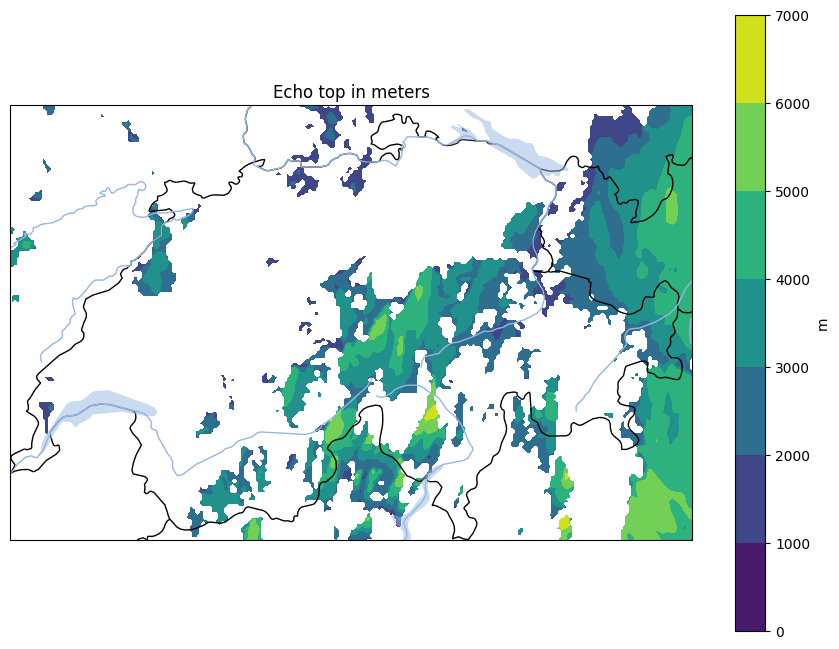

In [4]:
import matplotlib.pyplot as plt
from cartopy import crs as ccrs
from cartopy import feature as cfeature

crs = ccrs.epsg(21781)
fig = plt.figure(figsize=(11, 8))
ax = fig.add_subplot(1, 1, 1, projection=crs)

f = echo_top_lv03.squeeze()
c = ax.contourf(dst.x, dst.y, f.values, transform=crs)
fig.colorbar(c, label="m")

ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

ax.set_title("Echo top in meters")
